### Classification pipeline - steps 1-2 + final results

In [1]:
import pandas as pd

from utils import test_predictions, compute_metrics, print_values
from plots import stats_plot, distr_plot

In [2]:
# Chosen model
model_name = 'ernie-m-large'  
model_title = 'Ernie-M Large'

# Step 1 classification
### Input data
gold_input = 'data/gold-annotation.parquet'

### Training results
cls1_train_stats = f'data/{model_name}-epoch-stats.parquet'
cls1_val_preds = f'data/{model_name}-val-predictions.parquet'

### Predicting results
cls1_prod_preds = f'data/{model_name}-test-predictions.parquet'


# Step 2 classification
### Input data
cls2_input = 'data/cls2-input.parquet'

### Training results
cls2_train_stats = f'data/cls2-{model_name}-epoch-stats.parquet'
cls2_val_preds = f'data/cls2-{model_name}-val-predictions.parquet'

### Predicting results
cls2_prod_preds = f'data/cls2-{model_name}-test-predictions.parquet'


# Final (silver) validation results
silver_val = 'data/silver-annotation.parquet'

# All EstTexts
est_articles = '../../est-dataset/all-est-news.parquet'


# Set threshold
set_threshold = 0.98


# Loading
def load(file, name=model_name):
    df = pd.read_parquet(file)
    # model_dict = {name: df}
    return df

cls1_train_stats_df = load(cls1_train_stats)
cls1_val_preds_df = load(cls1_val_preds)
cls1_prod_preds_df = load(cls1_prod_preds)
cls2_train_stats_df = load(cls2_train_stats)
cls2_val_preds_df = load(cls2_val_preds)
cls2_prod_preds_df = load(cls2_prod_preds)
silver_val_df = load(silver_val)
esttexts_df = load(est_articles)

#### Step 1 classification

In [3]:
# Input dataset

gold_input_df = pd.read_parquet(gold_input)
gold_input_df['Label'].value_counts()

Label
0    306
1    194
Name: count, dtype: int64

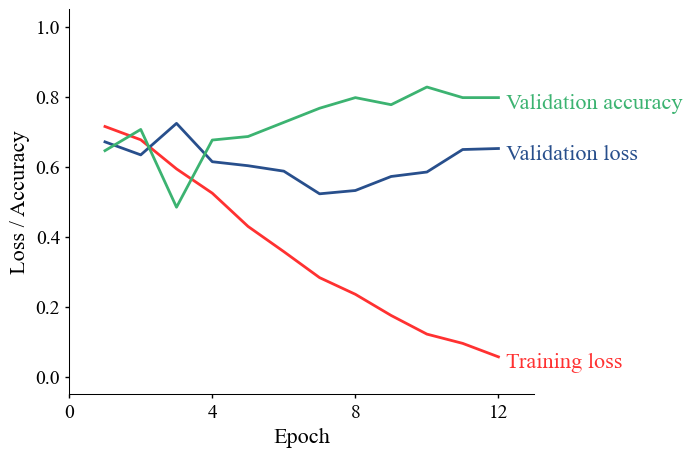

In [4]:
# Training results

stats_plot(cls1_train_stats_df, title="")

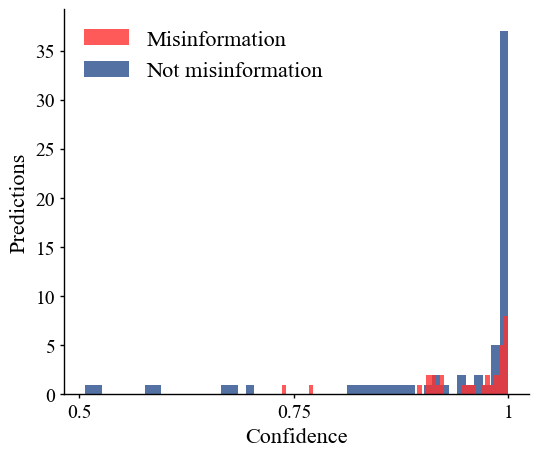

CLS1 validation:
Threshold 0.98:
Sample Size: 58/99
F1 Score: 0.8750 ± 0.0851
Precision: 0.8750 ± 0.0851
Recall: 0.8750 ± 0.0851
Accuracy: 0.9310 ± 0.0652



In [6]:
# Validation results

distr_plot(cls1_val_preds_df, "", 0)

cls1_val_preds_df_label = pd.merge(cls1_val_preds_df, gold_input_df, on='EstText Index').rename(
    columns={'Label': 'True Label'}).drop(['Text'], axis=1)

print('CLS1 validation:')
compute_metrics(cls1_val_preds_df_label, set_threshold)

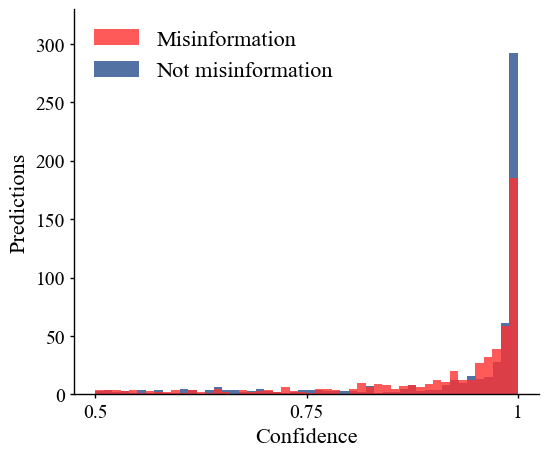

In [24]:
# Predictions on unlabelled set

distr_plot(cls1_prod_preds_df, '', 0, y_adj=0.7, output="cls1preds")

In [9]:
test_predictions(cls1_prod_preds_df, threshold=set_threshold)

Threshold 0.98:
Class 0: 352
Class 1: 242
Total predictions exceeding threshold: 594


#### Step 2 classification

In [10]:
# Input dataset

cls2_input_df = pd.read_parquet(cls2_input)
cls2_input_df['Label'].value_counts()

Label
0    660
1    436
Name: count, dtype: int64

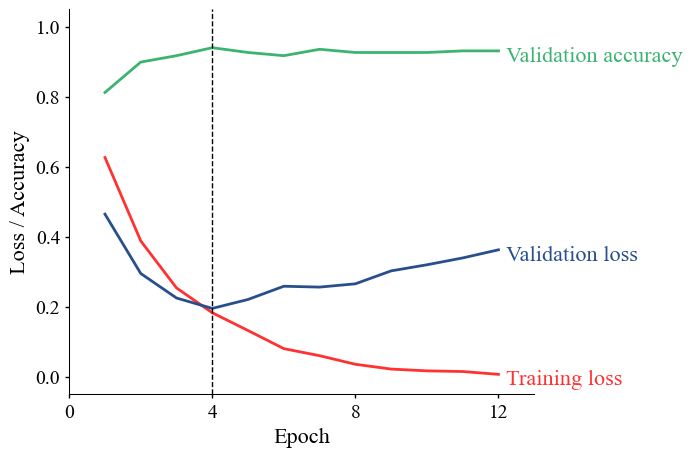

In [11]:
# Training results

stats_plot(cls2_train_stats_df, "", highlight=4, output="cls2stats")

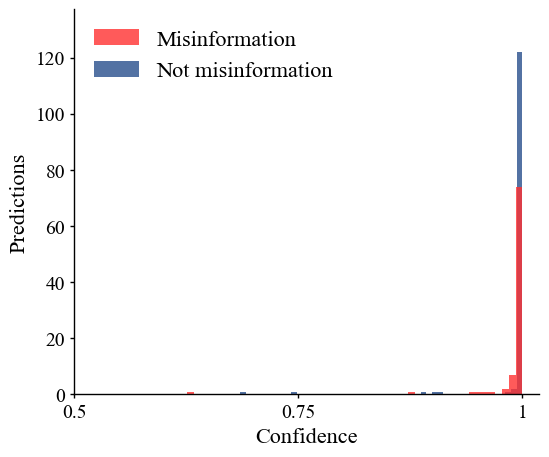

CLS2 validation:
Threshold 0.98:
Sample Size: 207/219
F1 Score: 0.9202 ± 0.0369
Precision: 0.9146 ± 0.0381
Recall: 0.9259 ± 0.0357
Accuracy: 0.9372 ± 0.0330



In [21]:
# Validation results

distr_plot(cls2_val_preds_df, "", 0, y_adj=0.7)

cls2_val_preds_df_label = pd.merge(cls2_val_preds_df, cls2_input_df, on='EstText Index').rename(
    columns={'Label': 'True Label'}).drop(['Text'], axis=1)

print('CLS2 validation:')
compute_metrics(cls2_val_preds_df_label, set_threshold)

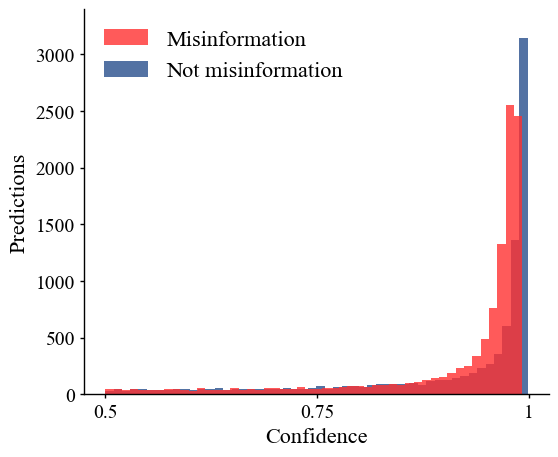

In [25]:
# Predictions on unlabelled set

distr_plot(cls2_prod_preds_df, "", y_adj=0.7, output="step2preds")

In [14]:
test_predictions(cls2_prod_preds_df, set_threshold)

Threshold 0.98:
Class 0: 4400
Class 1: 3301
Total predictions exceeding threshold: 7701


#### Final validation

In [15]:
final_val = pd.merge(silver_val_df, cls2_prod_preds_df, on='EstText Index').rename(columns={'Label': 'True Label'})
final_val_health = final_val[final_val['Health'] == 1]
final_val_no_health = final_val[final_val['Health'] == 0]

print('All data:')
compute_metrics(final_val, 0)

print('Only health-related articles:')
compute_metrics(final_val_health, 0)

print('Only not health-related articles:')
compute_metrics(final_val_no_health, 0)

All data:
Sample Size: 300/300
F1 Score: 0.8492 ± 0.0405
Precision: 0.7754 ± 0.0472
Recall: 0.9386 ± 0.0272
Accuracy: 0.8733 ± 0.0376

Only health-related articles:
Sample Size: 198/198
F1 Score: 0.8807 ± 0.0451
Precision: 0.8889 ± 0.0438
Recall: 0.8727 ± 0.0464
Accuracy: 0.9343 ± 0.0345

Only not health-related articles:
Sample Size: 102/102
F1 Score: 0.8252 ± 0.0737
Precision: 0.7024 ± 0.0887
Recall: 1.0000 ± 0.0000
Accuracy: 0.7549 ± 0.0835



In [16]:
# conf_mat_plot([final_val, final_val_health, final_val_no_health], 
#               [f'{model_title} final validation', f'{model_title} final validation: health', f'{model_title} final validation: non-health'])

In [17]:
# Looking at the predictions distribution by sites

all_preds = pd.read_parquet('data/EST-fake-news-dataset.parquet')
all_preds['Label'] = all_preds['Label (By Model)'].fillna(all_preds['Label (By Human)'])

all_neg = all_preds[all_preds['Label'] == 0]
all_pos = all_preds[all_preds['Label'] == 1]

print_values(all_neg, 'Website')

tervise.geenius.ee: 3210 (63.5%)
uueduudised.ee: 803 (15.9%)
telegram.ee: 614 (12.1%)
objektiiv.ee: 408 (8.1%)
delfi.ee: 4 (0.1%)
tervis.postimees.ee: 2 (0.0%)
novaator.err.ee: 2 (0.0%)
itk.ee: 1 (0.0%)
m.delfi.ee: 1 (0.0%)
suukool.ee: 1 (0.0%)
vikerraadio.err.ee: 1 (0.0%)
ohtuleht.ee: 1 (0.0%)
maaleht.delfi.ee: 1 (0.0%)
sternum.ee: 1 (0.0%)
eestinen.fi: 1 (0.0%)
minuaeg.com: 1 (0.0%)
forte.delfi.ee: 1 (0.0%)
haigekassa.ee: 1 (0.0%)
err.ee: 1 (0.0%)
rahvaalgatus.ee: 1 (0.0%)
aripaev.ee: 1 (0.0%)
ravimiamet.ee: 1 (0.0%)


In [18]:
all_preds['Label'].value_counts()

Label
0    5058
1    3737
Name: count, dtype: Int64